### Temporal Graph Neural Network (TGNN) for Fraud Detection

This notebook contains all the implementation steps for building a Temporal Graph Neural Network (TGNN) model to detect money laundering activities in transaction data.

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
from src.data_prep import TemporalGraphDataProcessor
from src.utils import load_config
from src.train import ModelTrainer
from src.evaluate import ModelEvaluator

In [3]:
config = load_config("config.yaml")
processor = TemporalGraphDataProcessor(config['preprocessing']['time_window'])
df = processor.load_and_preprocess()                                                # Load and simple preprocessing
df_account_stats = processor.calculate_account_features(df)       # Calculate account-level features over a time window
df = processor.engineer_features(df)                              # Engineer transaction-level features
snapshots, global_num_nodes = processor.create_temporal_snapshots(df, df_account_stats) # Create temporal graph snapshots

2025-11-09 21:18:28 - INFO - Loading and preprocessing data...
2025-11-09 21:18:32 - INFO - Loaded 9504852 transactions
2025-11-09 21:18:32 - INFO - Suspicious transactions: 9873 (0.104%)
2025-11-09 21:18:32 - INFO - Calculating account-level features over time window: 7D
2025-11-09 21:18:32 - INFO - Processing window 2022-10-07 to 2022-10-13
2025-11-09 21:18:34 - INFO - Processing window 2022-10-14 to 2022-10-20
2025-11-09 21:18:36 - INFO - Processing window 2022-10-21 to 2022-10-27
2025-11-09 21:18:38 - INFO - Processing window 2022-10-28 to 2022-11-03
2025-11-09 21:18:40 - INFO - Processing window 2022-11-04 to 2022-11-10
2025-11-09 21:18:43 - INFO - Processing window 2022-11-11 to 2022-11-17
2025-11-09 21:18:45 - INFO - Processing window 2022-11-18 to 2022-11-24
2025-11-09 21:18:47 - INFO - Processing window 2022-11-25 to 2022-12-01
2025-11-09 21:18:49 - INFO - Processing window 2022-12-02 to 2022-12-08
2025-11-09 21:18:51 - INFO - Processing window 2022-12-09 to 2022-12-15
2025-11

In [4]:
# Data splitting
train_size = int(len(snapshots) * (1 - config['preprocessing']['validation_split'] - config['preprocessing']['test_split']))
val_size = int(len(snapshots) * config['preprocessing']['validation_split'])

train_snaps = snapshots[:train_size]
val_snaps = snapshots[train_size:train_size + val_size]
test_snaps = snapshots[train_size + val_size:]

In [5]:
# training
trainer = ModelTrainer(config)
results = trainer.train_model(train_snaps, val_snaps, global_num_nodes)

2025-11-09 21:21:58 - INFO - Using device: cuda


2025-11-09 21:22:04 - INFO - Epoch 1: Train Loss(x1e3): 6.3757, Val Loss(x1e3): 1.0880, F2: 0.0060, Threshold: 0.050, Recall: 0.0137, LR: 0.000500
2025-11-09 21:22:09 - INFO - Epoch 2: Train Loss(x1e3): 1.3601, Val Loss(x1e3): 1.3045, F2: 0.0000, Threshold: 0.500, Recall: 0.0000, LR: 0.000500
2025-11-09 21:22:14 - INFO - Epoch 3: Train Loss(x1e3): 1.1724, Val Loss(x1e3): 0.9689, F2: 0.0077, Threshold: 0.050, Recall: 0.0439, LR: 0.000500
2025-11-09 21:22:19 - INFO - Epoch 4: Train Loss(x1e3): 0.9176, Val Loss(x1e3): 0.8001, F2: 0.0081, Threshold: 0.050, Recall: 0.2586, LR: 0.000500
2025-11-09 21:22:23 - INFO - Epoch 5: Train Loss(x1e3): 0.8136, Val Loss(x1e3): 0.7228, F2: 0.0074, Threshold: 0.050, Recall: 0.5377, LR: 0.000500
2025-11-09 21:22:28 - INFO - Epoch 6: Train Loss(x1e3): 0.7877, Val Loss(x1e3): 0.6963, F2: 0.0082, Threshold: 0.100, Recall: 0.1488, LR: 0.000500
2025-11-09 21:22:33 - INFO - Epoch 7: Train Loss(x1e3): 0.7635, Val Loss(x1e3): 0.6860, F2: 0.0085, Threshold: 0.100, 

In [9]:
# Evaluation
model = results['model']
evaluator = ModelEvaluator(config)

In [10]:
# Validation set evaluation
val_snapshots = snapshots[train_size: train_size + val_size]
val_metrics, val_probs, val_labels = evaluator.evaluate_model(
    model, val_snapshots, global_num_nodes, 'val', plot=False
)

2025-11-09 21:30:48 - INFO - Evaluating on val set...
2025-11-09 21:30:51 - INFO - VAL RESULTS:
2025-11-09 21:30:51 - INFO - Optimal Threshold: 0.400
2025-11-09 21:30:51 - INFO - F2 Score: 0.8250
2025-11-09 21:30:51 - INFO - Precision: 0.8192
2025-11-09 21:30:51 - INFO - Recall: 0.8265
2025-11-09 21:30:51 - INFO - PR-AUC: 0.8615


In [11]:
threshold = val_metrics['threshold']
test_snapshots = snapshots[train_size + val_size:]
test_metrics, test_probs, test_labels = evaluator.evaluate_model(
    model, test_snapshots, global_num_nodes, 'test', threshold=threshold, plot=False
)

2025-11-09 21:30:52 - INFO - Evaluating on test set...
2025-11-09 21:30:53 - INFO - TEST RESULTS:
2025-11-09 21:30:53 - INFO - Optimal Threshold: 0.400
2025-11-09 21:30:53 - INFO - F2 Score: 0.8151
2025-11-09 21:30:53 - INFO - Precision: 0.7820
2025-11-09 21:30:53 - INFO - Recall: 0.8239
2025-11-09 21:30:53 - INFO - PR-AUC: 0.8545


In [19]:
def plot_precision_recall_curve(labels, probs, title_suffix=''):
    """Plot precision-recall curve with average precision score"""
    from sklearn.metrics import precision_recall_curve, average_precision_score
    import matplotlib.pyplot as plt
    
    precision, recall, _ = precision_recall_curve(labels, probs)
    ap = average_precision_score(labels, probs)
    
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (AP={ap:.3f}){title_suffix}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return ap

def plot_confusion_matrix(labels, probs, threshold, title_suffix=''):
    """Plot confusion matrix for given threshold"""
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Calculate predictions using threshold
    preds = (probs >= threshold).astype(int)
    cm = confusion_matrix(labels, preds)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                square=True,
                xticklabels=['Non-suspicious', 'Suspicious'],
                yticklabels=['Non-suspicious', 'Suspicious'])
    plt.title(f'Confusion Matrix - threshold: {threshold:.4f}{title_suffix}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return cm

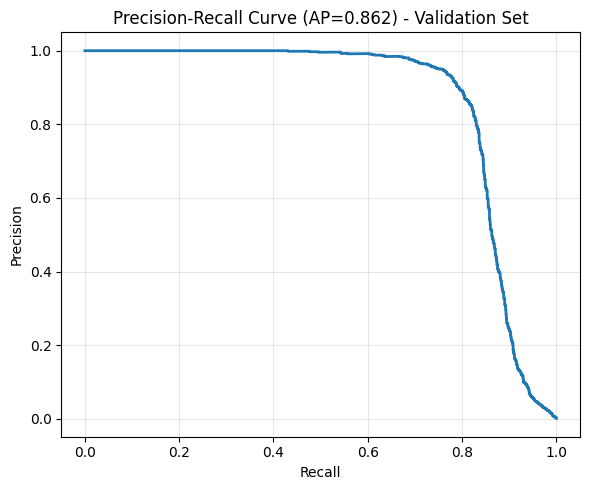

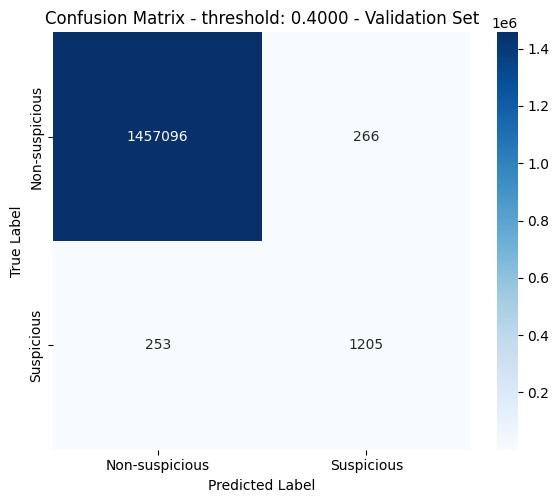

In [21]:
ap_score_val = plot_precision_recall_curve(val_labels, val_probs, title_suffix=' - Validation Set')
cm_val = plot_confusion_matrix(val_labels, val_probs, threshold, title_suffix=' - Validation Set')

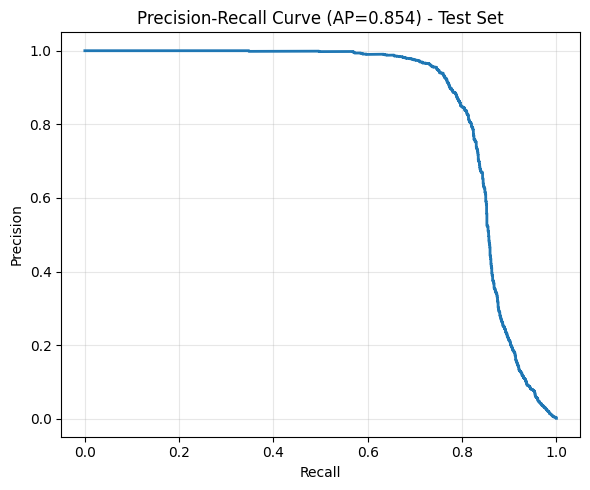

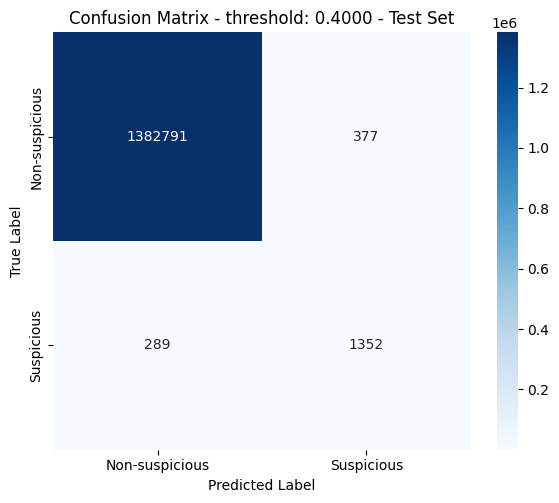

In [22]:
ap_score_test = plot_precision_recall_curve(test_labels, test_probs, title_suffix=' - Test Set')
cm_test = plot_confusion_matrix(test_labels, test_probs, threshold, title_suffix=' - Test Set')